# Batch Processing for Multiple-Choice Questions

# 1. Install Litelines

In [1]:
# %pip install --quiet --upgrade litelines

## 2. Download a model and its tokenizer

In [2]:
# Use cuda for faster inference
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
assert device == torch.device("cuda"), "In the Runtime tab, please Change runtime type to GPU"

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device)

## 3. Prepare the inputs to the LLM

In [4]:
user_inputs = ["What is the capital of France?", "What is the capital of Italy?", "What is the capital of Spain?", "What's the capital of Portugal?", "What's the capital of Austria?", "What's the capital of Germany?"]
alternatives = """
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna
"""

for user_input in user_inputs:
    print(user_input + alternatives)

What is the capital of France?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

What is the capital of Italy?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

What is the capital of Spain?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

What's the capital of Portugal?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

What's the capital of Austria?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

What's the capital of Germany?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna



In [5]:
messages = [[{"role": "user", "content": user_input + alternatives}] for user_input in user_inputs]
formatted_messages = [
    tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True) for message in messages
]
for formatted_message in formatted_messages:
    print(formatted_message)

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
What is the capital of France?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna
<|im_end|>
<|im_start|>assistant

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
What is the capital of Italy?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna
<|im_end|>
<|im_start|>assistant

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
What is the capital of Spain?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna
<|im_end|>
<|im_start|>assistant

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
What's the capital of Portugal?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna
<|im_end|>
<|im_start|>assistant

<|im_start|>system
You are Qwen, created by A

## 4. Define a processor through a regular expression

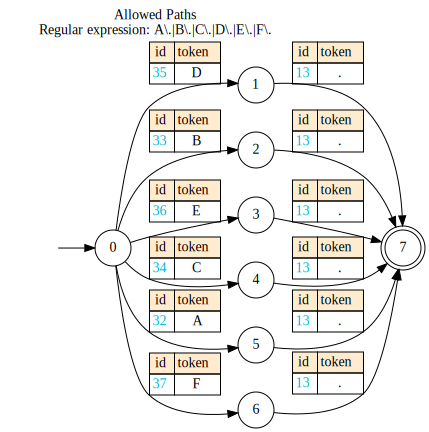

In [6]:
from litelines.transformers import SchemaProcessor

processor = SchemaProcessor(response_format=r"A\.|B\.|C\.|D\.|E\.|F\.", tokenizer=tokenizer)
processor.show_graph()

## 5. Generate a structured response sequentially

In [7]:
import time

In [8]:
start_time_seq = time.time()
assistant_responses = []
for i in range(6):
    inputs = tokenizer(
        formatted_messages[i], return_tensors="pt", padding=True, truncation=True
    ).to(device)
    prompt_length = inputs['input_ids'].shape[-1]
    output = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        logits_processor=[processor],
        temperature=0.1,
    )
    assistant_response = tokenizer.decode(output[0][prompt_length:], skip_special_tokens=True)
    print(assistant_response)
    assistant_responses.append(assistant_response)
end_time_seq = time.time()

B.
C.
A.
E.
F.
D.


In [9]:
print(f"Total time: {end_time_seq-start_time_seq:,.2f}s")

Total time: 2.58s


## 5. Generate a structured response in a batch

In [10]:
start_time_batch = time.time()
inputs = tokenizer(
    formatted_messages,
    return_tensors="pt",
    padding=True,
    truncation=True
).to(device)
prompt_length = inputs['input_ids'].shape[-1]
outputs = model.generate(
    inputs.input_ids,
    attention_mask=inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    logits_processor=[processor],
    temperature=0.1
)
generated_texts = tokenizer.batch_decode([output[prompt_length:] for output in outputs], skip_special_tokens=True)
for i in range(6):
    print(generated_texts[i])
end_time_batch = time.time()

B.
C.
A.
E.
F.
D.


In [11]:
print(f"Total time: {end_time_batch-start_time_batch:,.2f}s")

Total time: 0.43s


In [12]:
print(f"Sequential takes {(end_time_seq-start_time_seq)/(end_time_batch-start_time_batch):,.2f} the time of batch")

Sequential takes 6.01 the time of batch


In [13]:
formatted_strings = [f"Question: {user_inputs[i]+alternatives}\n\x1b[34mResponse:\x1b[0m \x1b[31m{generated_texts[i]}\x1b[0m" for i in range(len(user_inputs))]
for string in formatted_strings:
    print(string)
    print()

Question: What is the capital of France?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

Response: B.

Question: What is the capital of Italy?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

Response: C.

Question: What is the capital of Spain?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

Response: A.

Question: What's the capital of Portugal?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

Response: E.

Question: What's the capital of Austria?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

Response: F.

Question: What's the capital of Germany?
A) Madrid
B) Paris
C) Rome
D) Berlin
E) Lisbonne
F) Vienna

Response: D.



## 6. Visualize the selected paths

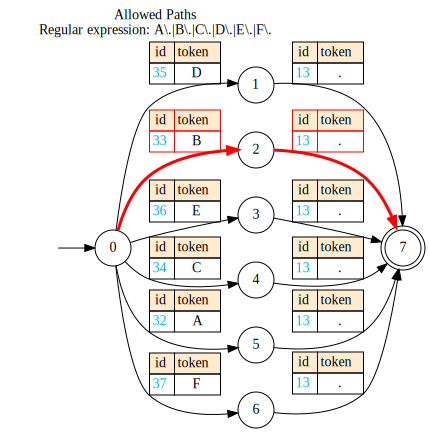

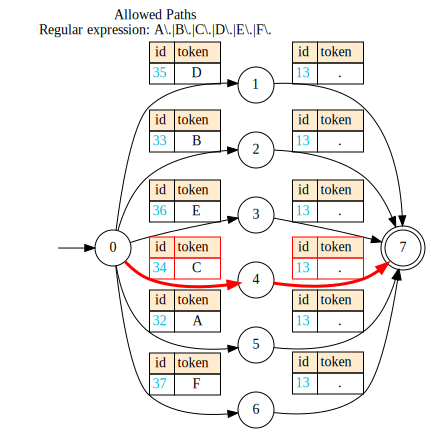

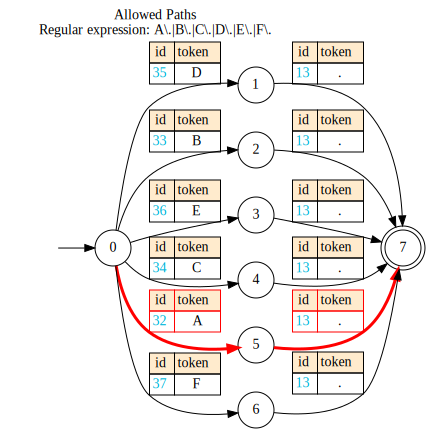

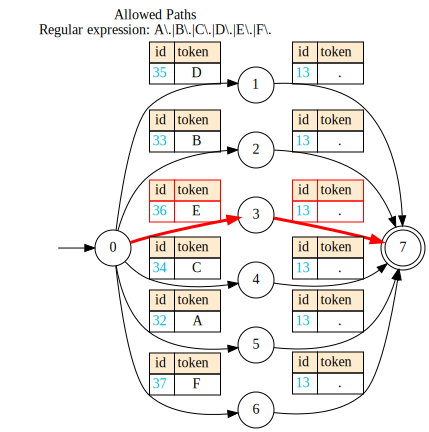

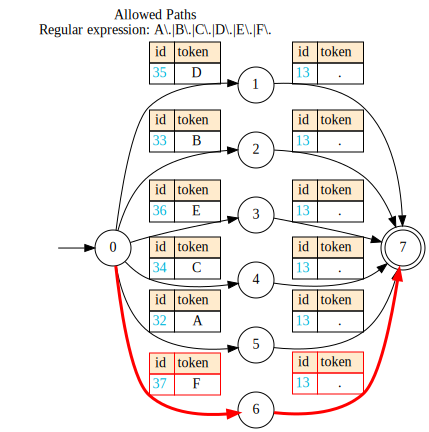

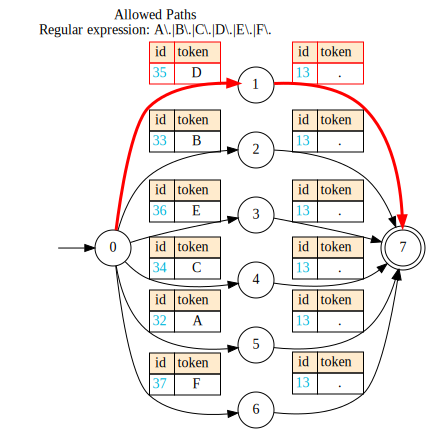

In [14]:
for i in range(6):
    processor.show_graph(batch_number=i)